In [1]:
import numpy as np
import matplotlib.pyplot as plt

import bayesflow as bf

import keras

Defaulting to JAX.
To override, set the KERAS_BACKEND environment variable before importing bayesflow.
See: https://keras.io/getting_started/#configuring-your-backend
INFO:2026-02-04 17:27:09,660:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


## Simulator and Adapter
As a quick demo, we use the widely overused Lotka-Voleterra simulator.

In [2]:
simulator = bf.simulators.LotkaVolterra(flatten=False)

adapter = (
    bf.Adapter()
    .to_array()
    .convert_dtype("float32", "float64")
    .rename("observables", "summary_variables")
    .rename("parameters", "inference_variables")
)

## Ensemble Creation

In [3]:
# We can either use separate or shared summary networks
# In this case, we define a single, thus shared, summary network and initialize separate inference networks.
# Note: This means that the summary network's gradients are the sum over all forward passes with the different inference networks.
#       Since the gradients will not be aligned this will not really be an effective learning rate increase by factor 3,
#       but still it will likely update faster than when training one with a single inference network.


summary_network = bf.networks.TimeSeriesNetwork(kernel_sizes=2, recurrent_dim=32, skip_steps=1)

approximator = bf.approximators.EnsembleApproximator({
    "nf": bf.ContinuousApproximator(
            adapter=adapter,
            inference_network=bf.networks.CouplingFlow(),
            summary_network=summary_network,
        ),
    "cm": bf.ContinuousApproximator(
            adapter=adapter,
            inference_network=bf.networks.StableConsistencyModel(),
            summary_network=summary_network,
        ),
    "mvn": bf.PointApproximator(
            adapter=adapter,
            inference_network=bf.networks.PointInferenceNetwork(scores=dict(mvn=bf.scores.MultivariateNormalScore())),
            summary_network=summary_network,
        ),
})

## Low-Level Training
Create a relatively small training data set and choose standard optimizer settings. In practice, you would train for much longer. Moreover, different model types may need different training lengths.

In [4]:
epochs = 20
batch_size = 32
num_batches = 256
num_train_sims = batch_size * num_batches
num_val_sims = 256

train_sims = simulator.sample(num_train_sims)
val_sims = simulator.sample(num_val_sims)

In [5]:
dataset = bf.datasets.EnsembleDataset(
    bf.datasets.OfflineDataset(
        data=train_sims,
        batch_size=batch_size,
        adapter=adapter,
    ),
    ensemble_size=len(approximator.approximators),
)

total_steps = int(epochs * num_batches)
warmup_steps = int(0.05 * epochs * num_batches)
decay_steps = total_steps - warmup_steps

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1 * 5e-4,
    warmup_target=5e-4,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0,
)
optimizer = keras.optimizers.AdamW(learning_rate, clipnorm=1.5)
approximator.compile(optimizer=optimizer)

INFO:bayesflow:EnsembleIndexedDataset: ensemble_size=3, batch_size=32, num_samples=8192, data_reuse=1.0 -> reduction_factor=1.00, window_size=8192, steps_per_epoch=256. Overlap is enforced at the subdataset level (member-specific windows into the global index pool).


In [6]:
history = approximator.fit(dataset=dataset, epochs=epochs, validation_data=adapter(val_sims))

INFO:bayesflow:Fitting on dataset instance of EnsembleDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - cm/loss: -1.4952 - loss: 3.9681 - mvn/loss: 2.7631 - mvn/mvn/inference_mvn: 2.7631 - nf/loss: 2.7001 - val_cm/loss: -1.6663 - val_loss: 2.4334 - val_mvn/loss: 1.9451 - val_mvn/mvn/inference_mvn: 1.9451 - val_nf/loss: 2.1546
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - cm/loss: -1.9547 - loss: 1.7159 - mvn/loss: 1.7614 - mvn/mvn/inference_mvn: 1.7614 - nf/loss: 1.9092 - val_cm/loss: -1.9383 - val_loss: -0.1834 - val_mvn/loss: 1.0323 - val_mvn/mvn/inference_mvn: 1.0323 - val_nf/loss: 0.7226
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - cm/loss: -1.9582 - loss: 0.5806 - mvn/loss: 1.6458 - mvn/mvn/inference_mvn: 1.6458 - nf/loss: 0.8929 - val_cm/loss: -2.0197 - val_loss: -1.7352 - val_mvn/loss: 0.3425 - val_mvn/mvn/inference_mvn: 0.3425 - val_nf/loss: -0.0580
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - cm/loss: -1.9360 - loss: -1.3922 - mvn/loss: 1.2456 - mvn/mvn/inference_mvn: 1.2456 - nf/loss: -0.7018 - va

In [ ]:
title_args = dict(y=1.02, size=15)

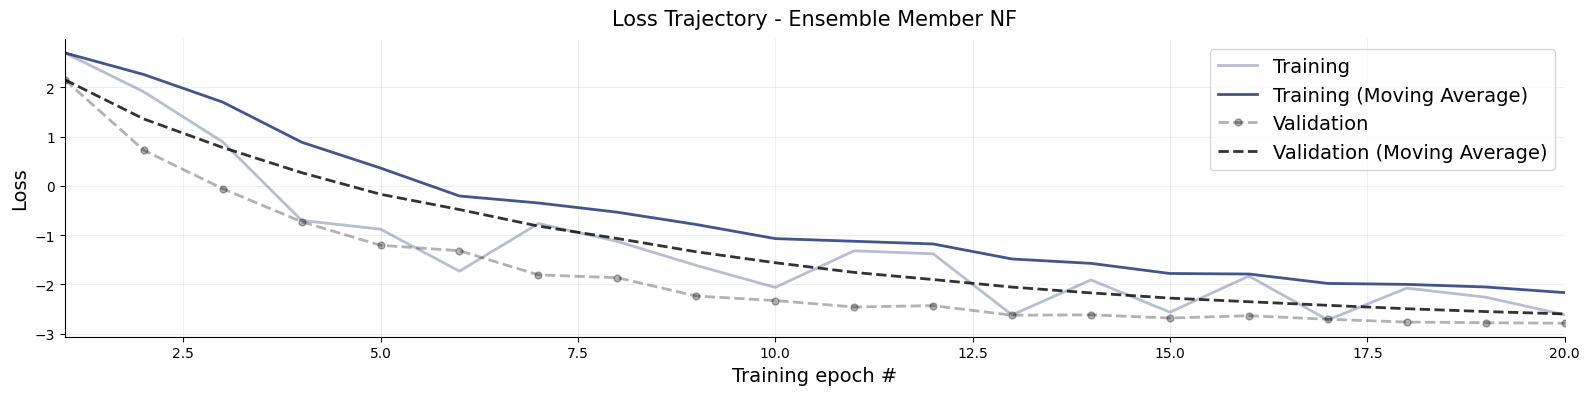

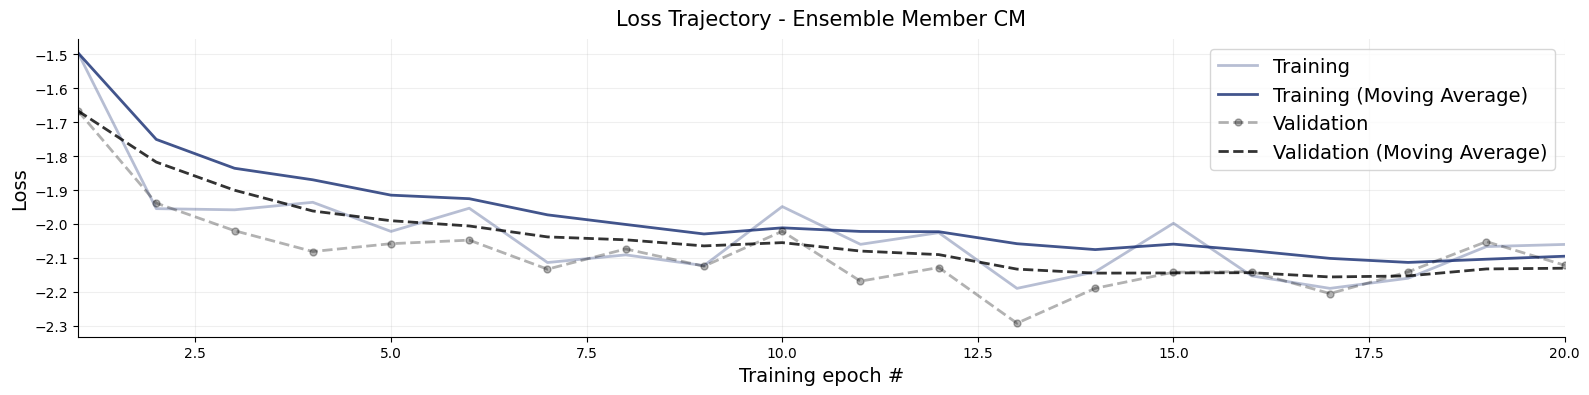

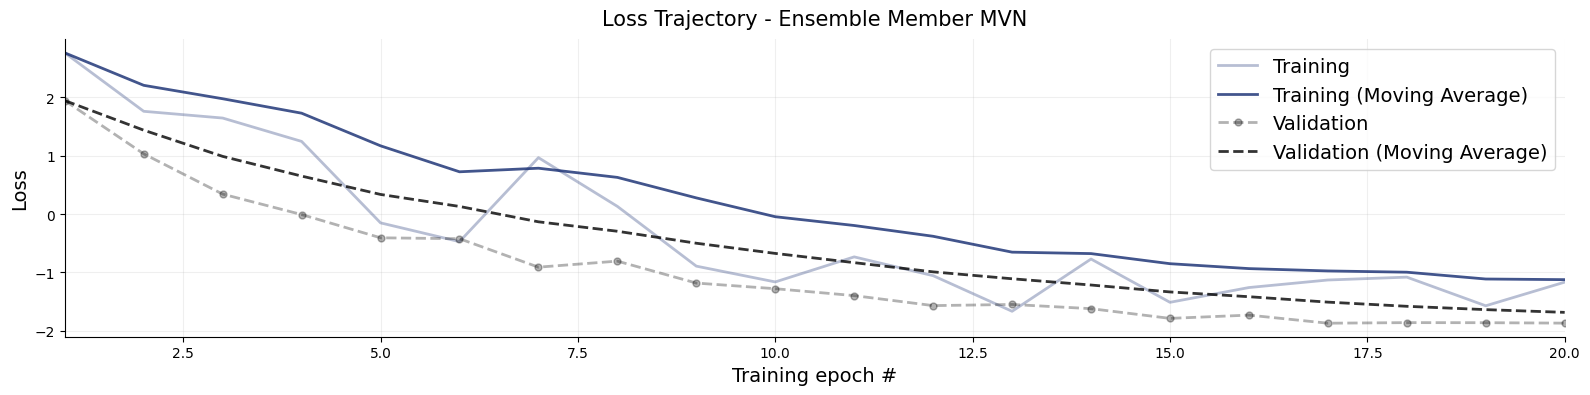

In [8]:

for k,v in approximator.approximators.items():
    f = bf.diagnostics.loss(history, train_key=f"{k}/loss", val_key=f"val_{k}/loss")
    f.gca().set_title(f"Loss Trajectory - Ensemble Member {k.upper()}", **title_args)

In [9]:
num_samples = 500

# Obtain posterior draws from all ensemble members (using the optional keyword arg member_weights).
marginal_draws = approximator.sample(conditions=val_sims, num_samples=num_samples, member_weights=dict(nf=0.1, cm=0.8, mvn=0.1))

# post_draws is a dictionary of draws with one element per named parameters
keras.tree.map_structure(keras.ops.shape, marginal_draws)

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

{'parameters': (256, 500, 4)}

In [10]:
# Obtain posterior draws separately for each ensemble member.
post_draws = approximator.sample_separate(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
keras.tree.map_structure(keras.ops.shape, post_draws)

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

{'nf': {'parameters': (256, 500, 4)},
 'cm': {'parameters': (256, 500, 4)},
 'mvn': {'parameters': (256, 500, 4)}}

## Validation

### Recovery per Ensemble Member

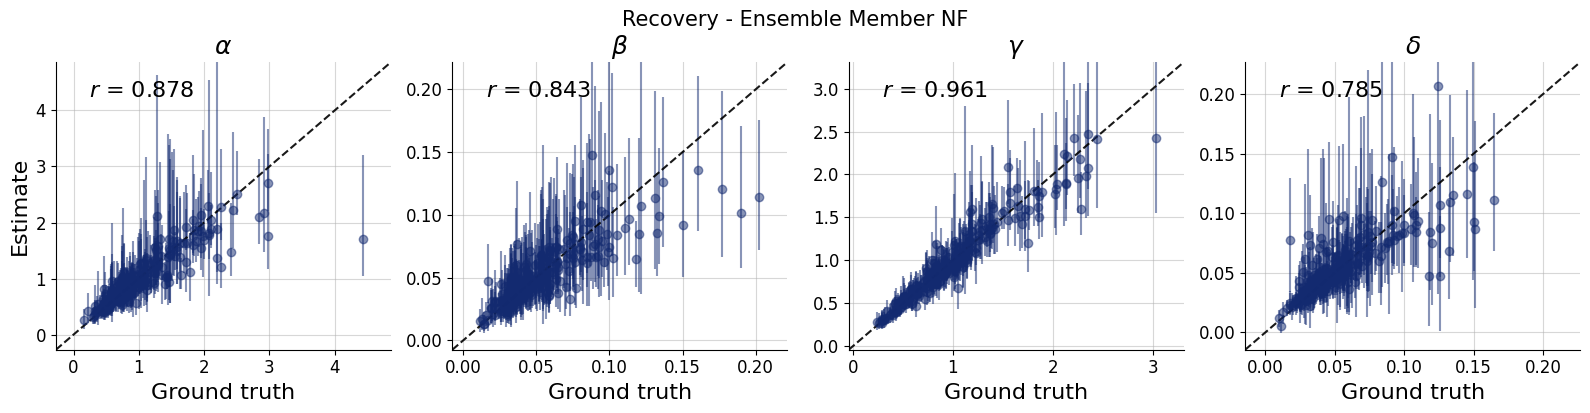

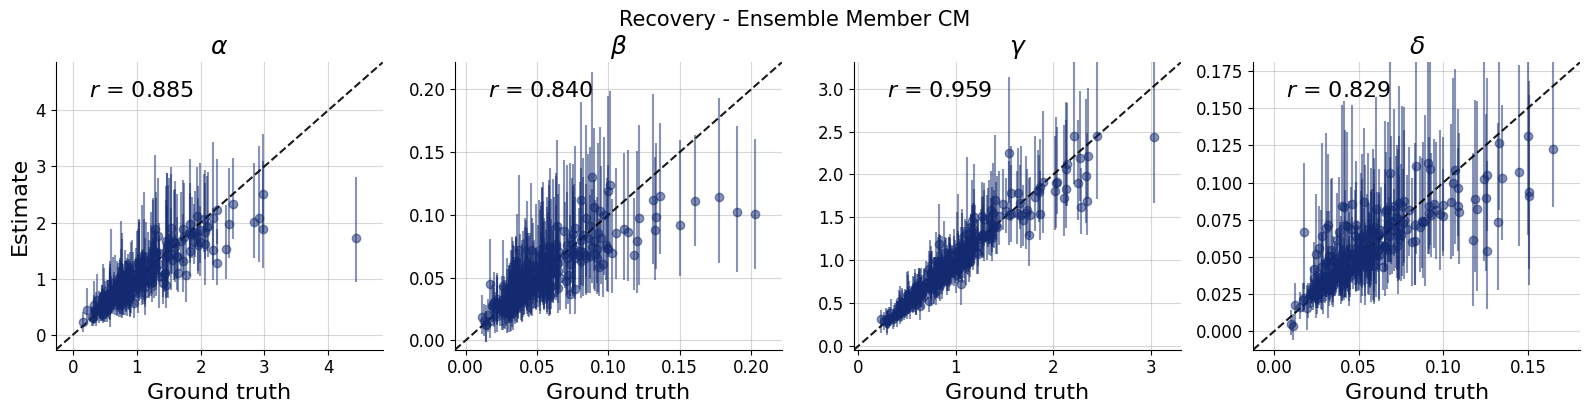

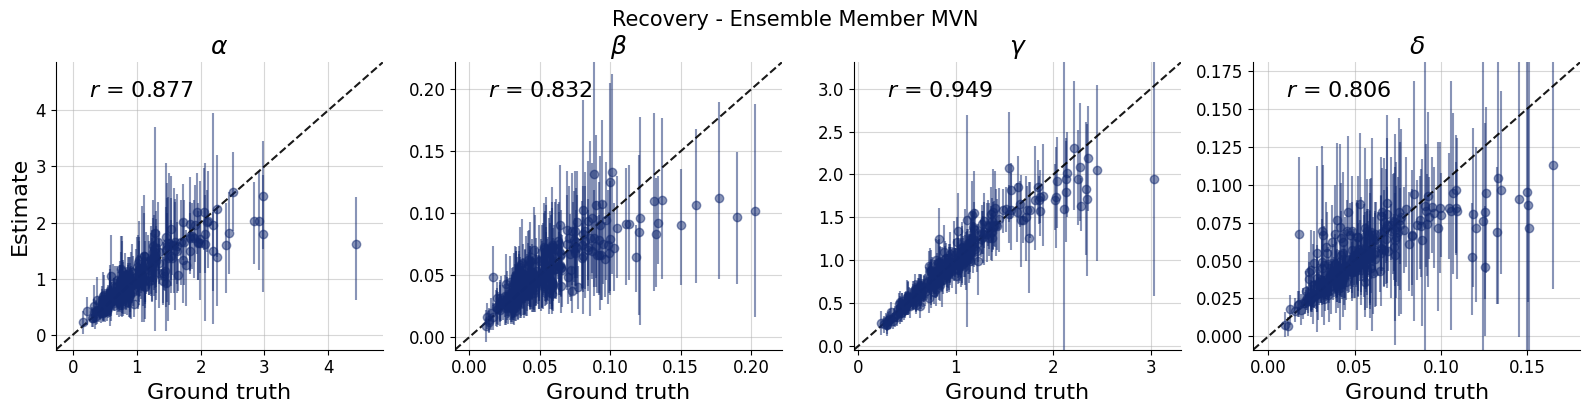

In [11]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
dataset_id = 0
for k,v in post_draws.items():
    f = bf.diagnostics.recovery(v, val_sims, variable_names=par_names, figsize=(16, 4))
    f.suptitle(f"Recovery - Ensemble Member {k.upper()}", **title_args)

### Simulation-Based Calibration per Ensemble Member

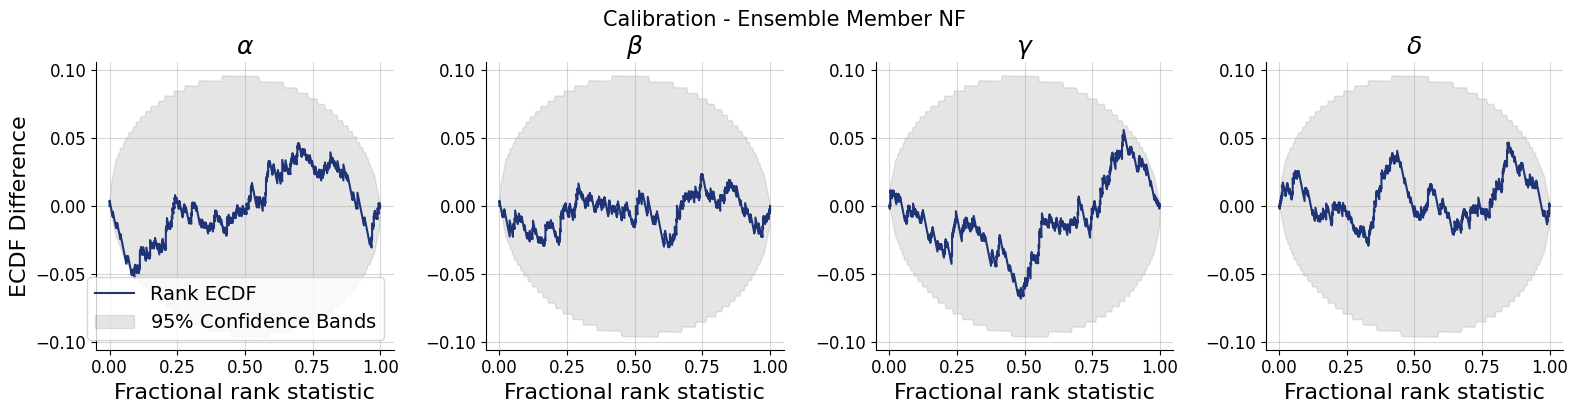

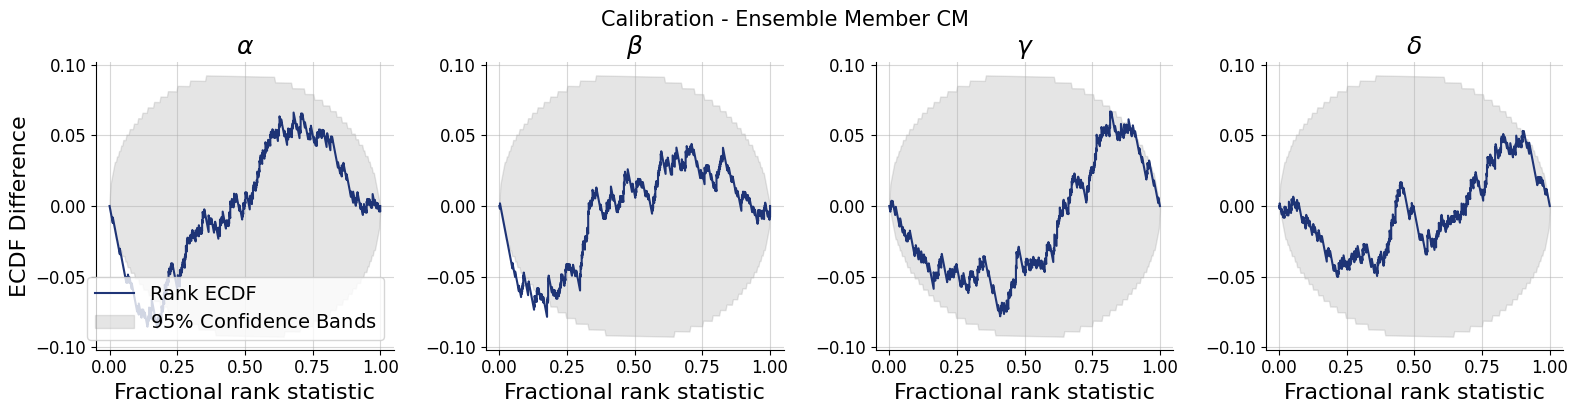

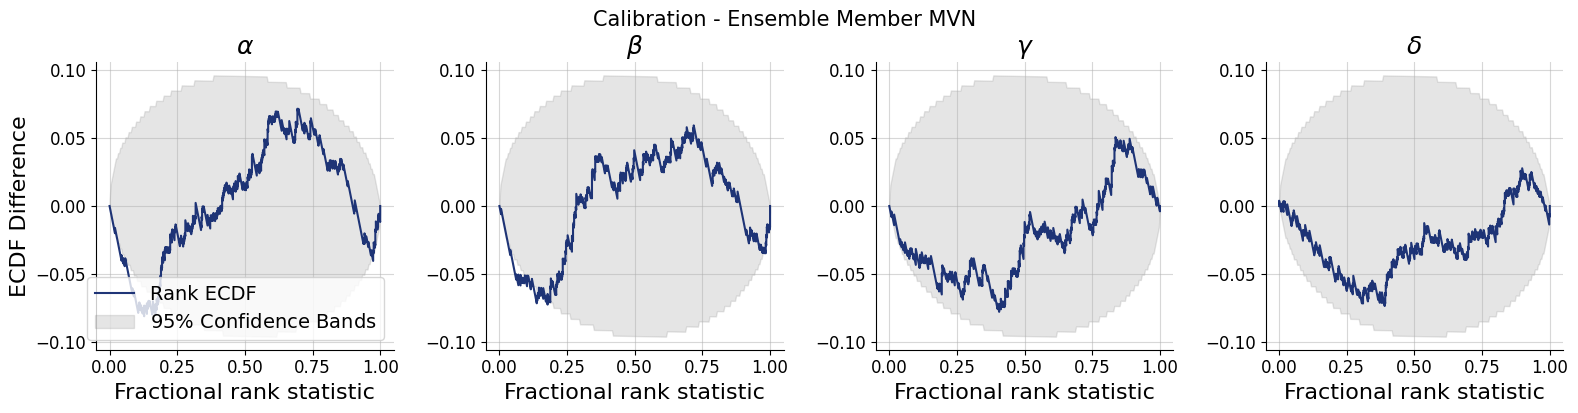

In [12]:
for k,v in post_draws.items():
    f = bf.diagnostics.calibration_ecdf(v, val_sims, variable_names=par_names, difference=True, figsize=(16, 4))
    f.suptitle(f"Calibration - Ensemble Member {k.upper()}", **title_args)

### Posterior Predictive Checks

In [110]:
id = 5
simulator.subsample = None

dataset = val_sims["observables"][id]
draws_per_dataset = marginal_draws["parameters"][id]

resims = np.concatenate([simulator.sample(1, parameters=draw)["observables"] for draw in draws_per_dataset])

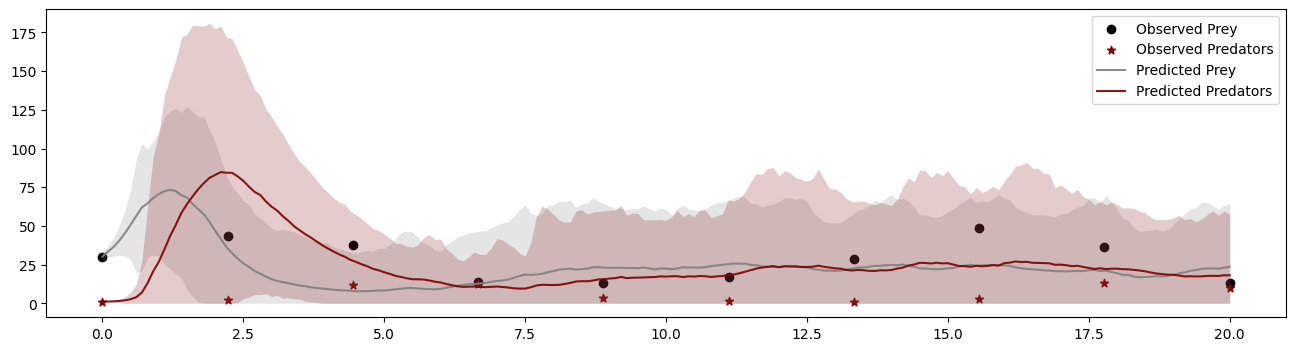

In [14]:
t_obs = np.linspace(0, simulator.T, dataset.shape[0])
t_sim = np.linspace(0, simulator.T, resims.shape[1])

mean = resims.mean(axis=0)
std  = resims.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.scatter(t_obs, dataset[:, 0], color="black", label="Observed Prey")
ax.scatter(t_obs, dataset[:, 1], color="maroon", label="Observed Predators", marker="*")

# Prey
ax.plot(t_sim, mean[:, 0], color="gray", alpha=0.9, label="Predicted Prey")
ax.fill_between(t_sim, np.clip(mean[:, 0] - std[:, 0], 0, None), mean[:, 0] + std[:, 0],
                color="gray", alpha=0.2, linewidth=0)

# Predators
ax.plot(t_sim, mean[:, 1], color="maroon", alpha=0.9, label="Predicted Predators")
ax.fill_between(t_sim, np.clip(mean[:, 1] - std[:, 1], 0, None), mean[:, 1] + std[:, 1],
                color="maroon", alpha=0.2, linewidth=0)

ax.legend()
